## Tutorial for SoccerCPD
Section 4 (except 4.1.3) in the paper

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from scipy.spatial import Delaunay
import rpy2.robjects.packages as rpackages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

In [2]:
%load_ext autoreload
%autoreload 2

from src.myconstants import *
from src.record_manager import RecordManager
from src.match import Match
from src.soccercpd import SoccerCPD
from src.form_manager import FormManager

### Execution of SoccerCPD using preprocessed GPS data

In [3]:
# Choose an activity to analyze
activity_id = 17985
rm = RecordManager()
activity_record, player_periods, roster, ugp = rm.load_activity_data(activity_id)
activity_record

activity_id            17985
team_id                  175
type                official
date                20200101
team_name          anonymous
home_away                  H
rotated_session            1
data_saved                 1
stats_saved                1
Name: 627, dtype: object

In [4]:
# GPS data after basic preprocessing
# (called "UGP data" as an abbreviation of "upgraded GPS data")
ugp

,player_id,session,gametime,unixtime,player_period,duration,x,y,speed
2020-01-01 18:26:49.100,1365.0,NaN,NaN,1.577903e+09,NaN,0.1,3362.0,8191.0,0.233274
2020-01-01 18:26:49.200,1365.0,NaN,NaN,1.577903e+09,NaN,0.1,3366.0,8185.0,0.318801
2020-01-01 18:26:49.300,1365.0,NaN,NaN,1.577903e+09,NaN,0.1,3366.0,8181.0,0.369413
2020-01-01 18:26:49.400,1365.0,NaN,NaN,1.577903e+09,NaN,0.1,3364.0,8178.0,0.391145
2020-01-01 18:26:49.500,1365.0,NaN,NaN,1.577903e+09,NaN,0.1,3360.0,8177.0,0.390031
...,...,...,...,...,...,...,...,...,...
2020-01-01 20:58:59.600,5608.0,NaN,NaN,1.577912e+09,NaN,0.1,4381.0,4760.0,5.710166
2020-01-01 20:58:59.700,5608.0,NaN,NaN,1.577912e+09,NaN,0.1,4370.0,4750.0,5.709115
2020-01-01 20:58:59.800,5608.0,NaN,NaN,1.577912e+09,NaN,0.1,4358.0,4740.0,5.708764
2020-01-01 20:58:59.900,5608.0,NaN,NaN,1.577912e+09,NaN,0.1,4347.0,4728.0,5.709465


In [5]:
# Further processing of UGP data using the official match log
match = Match(activity_record, player_periods, roster, ugp)

# (1) Filter in-play data from the measured data using the start, end, and substitution records
match.construct_inplay_ugp()

# (2) Rotate the pitch for one of the sessions so that the team always attacks from left to right
match.rotate_pitch()

match.ugp

,player_id,session,gametime,unixtime,player_period,duration,x,y,speed
2020-01-01 19:00:00.100,4181,1,00:00.1,1.577905e+09,1,0.1,4633.0,574.0,4.615196
2020-01-01 19:00:00.200,4181,1,00:00.2,1.577905e+09,1,0.1,4642.0,561.0,4.655973
2020-01-01 19:00:00.300,4181,1,00:00.3,1.577905e+09,1,0.1,4651.0,548.0,4.714858
2020-01-01 19:00:00.400,4181,1,00:00.4,1.577905e+09,1,0.1,4659.0,534.0,4.781228
2020-01-01 19:00:00.500,4181,1,00:00.5,1.577905e+09,1,0.1,4667.0,519.0,4.844462
...,...,...,...,...,...,...,...,...,...
2020-01-01 20:48:59.600,5527,2,47:59.6,1.577912e+09,4,0.1,1121.0,2817.0,1.856839
2020-01-01 20:48:59.700,5527,2,47:59.7,1.577912e+09,4,0.1,1128.0,2820.0,2.125829
2020-01-01 20:48:59.800,5527,2,47:59.8,1.577912e+09,4,0.1,1135.0,2824.0,2.457998
2020-01-01 20:48:59.900,5527,2,47:59.9,1.577912e+09,4,0.1,1142.0,2828.0,2.809422


In [26]:
# Install and import the R package 'gSeg' to be used in SoccerCPD
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
if not rpackages.isinstalled('gSeg'):
    utils.install_packages('gSeg')
rpackages.importr('gSeg')

# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='gseg_avg')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Load the pre-computed role assignment result
Session FGP data loaded and filtered from 'data/gseg_avg/fgp/17985.csv'.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 19:00:01 and 19:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 1040 
  Test statistic: 1940.918 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 987 
  Test statistic: 9364.465 
  Approximated p-value: 0 
A significant fine-tuned change-point at 19:18:13.

Applying g-segmentation to the sequence between 19:00:01 and 19:18:13...
Generalized edge-count statistic 

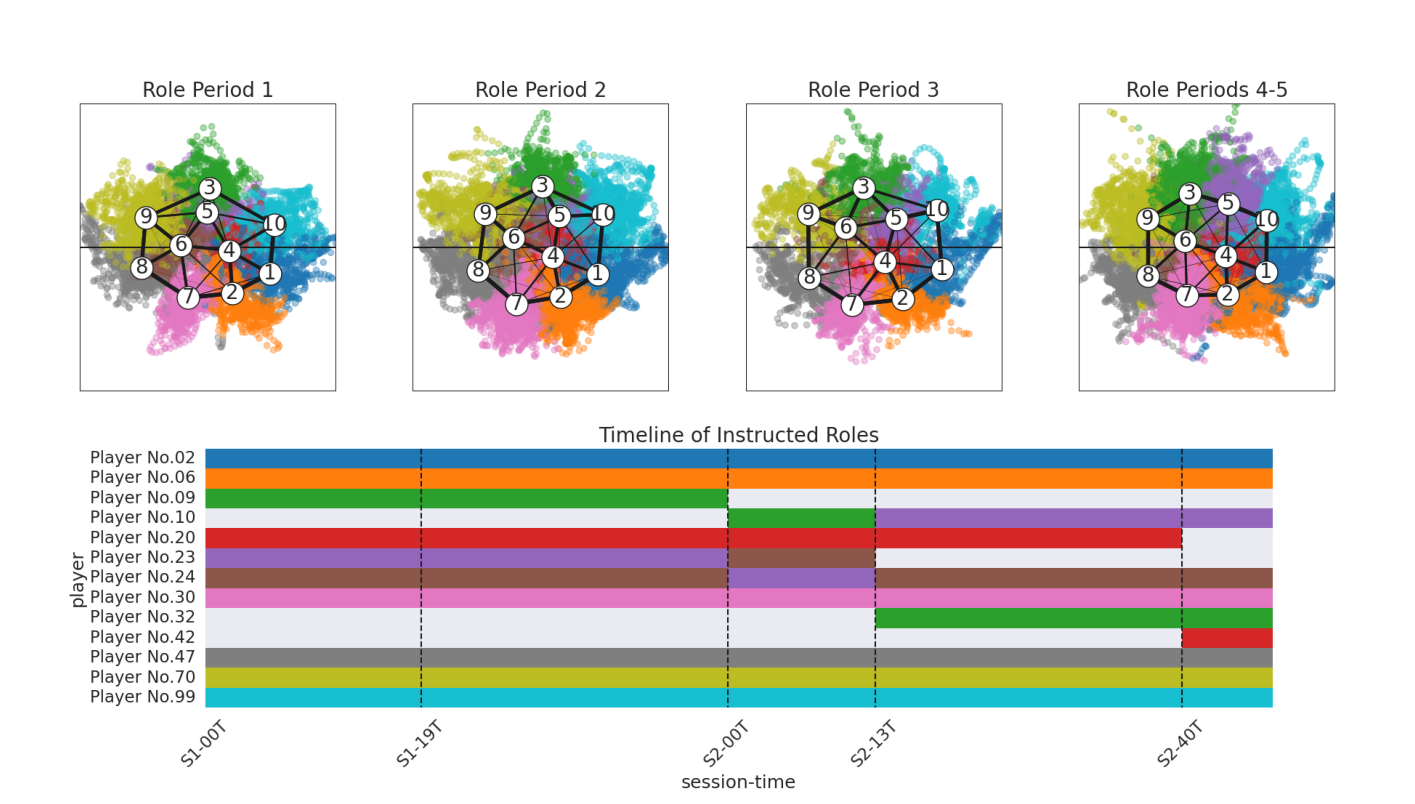

In [27]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

### Visualizing temporary Delaunay graphs
Fig. 2(a) in the paper

In [28]:
# FGP data (an abbreviation of "GPS data resulting from SoccerCPD")
activity_id = 17985
formcpd_type = 'gseg_avg'
fgp_path = f'{DIR_DATA}/{formcpd_type}/fgp/{activity_id}.csv'
fgp = pd.read_csv(fgp_path, sep=',', header=0)
fgp

,datetime,player_id,session,gametime,player_period,form_period,role_period,x,y,x_norm,y_norm,role,base_role,switch_rate,squad_num,player_name
0,2020-01-01 19:00:01,1365,1,00:01.0,1,1,1,4226.0,5741.0,-499.0,2366.4,8,8,0.2,47,P47
1,2020-01-01 19:00:02,1365,1,00:02.0,1,1,1,4235.0,5831.0,-496.5,2460.8,8,8,0.2,47,P47
2,2020-01-01 19:00:03,1365,1,00:03.0,1,1,1,4234.0,5903.0,-535.2,2553.4,8,8,0.0,47,P47
3,2020-01-01 19:00:04,1365,1,00:04.0,1,1,1,4267.0,5934.0,-569.1,2560.3,8,8,0.0,47,P47
4,2020-01-01 19:00:05,1365,1,00:05.0,1,1,1,4279.0,5875.0,-624.7,2417.9,8,8,0.0,47,P47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56352,2020-01-01 20:48:56,5608,2,47:56.0,4,4,5,798.0,3686.0,-753.9,348.1,7,7,0.5,30,P30
56353,2020-01-01 20:48:57,5608,2,47:57.0,4,4,5,811.0,3650.0,-616.5,379.1,7,7,0.5,30,P30
56354,2020-01-01 20:48:58,5608,2,47:58.0,4,4,5,860.0,3625.0,-524.1,456.0,7,7,0.5,30,P30
56355,2020-01-01 20:48:59,5608,2,47:59.0,4,4,5,756.0,3500.0,-633.6,371.3,7,7,0.5,30,P30


In [29]:
player_x = fgp.pivot_table(values='x', index='datetime', columns='player_name', aggfunc='first')
player_y = fgp.pivot_table(values='y', index='datetime', columns='player_name', aggfunc='first')
role_x = fgp.pivot_table(values='x', index='datetime', columns='role', aggfunc='first')
role_y = fgp.pivot_table(values='y', index='datetime', columns='role', aggfunc='first')
perms = fgp.pivot_table(values='role', index='datetime', columns='player_name', aggfunc='first')
perms

player_name,P02,P06,P09,P10,P20,P23,P24,P30,P32,P42,P47,P70,P99
datetime,,,,,,,,,,,,,
2020-01-01 19:00:01,1.0,2.0,5.0,NaN,4.0,3.0,6.0,7.0,NaN,NaN,8.0,9.0,10.0
2020-01-01 19:00:02,1.0,2.0,5.0,NaN,4.0,3.0,6.0,7.0,NaN,NaN,8.0,9.0,10.0
2020-01-01 19:00:03,1.0,2.0,3.0,NaN,4.0,5.0,6.0,7.0,NaN,NaN,8.0,9.0,10.0
2020-01-01 19:00:04,1.0,2.0,3.0,NaN,4.0,5.0,6.0,7.0,NaN,NaN,8.0,9.0,10.0
2020-01-01 19:00:05,1.0,2.0,3.0,NaN,4.0,5.0,6.0,7.0,NaN,NaN,8.0,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 20:48:56,1.0,4.0,NaN,3.0,NaN,NaN,6.0,7.0,9.0,2.0,8.0,5.0,10.0
2020-01-01 20:48:57,1.0,4.0,NaN,3.0,NaN,NaN,6.0,7.0,9.0,2.0,8.0,5.0,10.0
2020-01-01 20:48:58,1.0,4.0,NaN,3.0,NaN,NaN,6.0,7.0,9.0,2.0,8.0,5.0,10.0


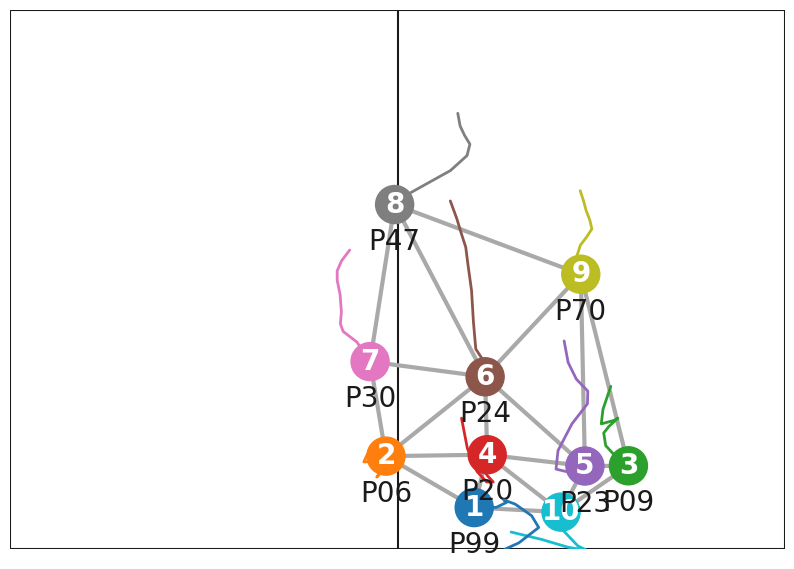

In [30]:
# Set the starting index of the animation
idx = 400
fontsize = 20

players = player_x.columns
roles = np.sort(fgp['role'].unique())
colors = plt.cm.tab10(range(10))

xlim = 10800
ylim = 7200

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set(xlim=(-500, xlim + 500), ylim=(-500, ylim + 500))
objs = []

def animate(t):
    ax.clear()
    # ax.set(xlim=(-500, xlim + 500), ylim=(-500, ylim + 500))
    ax.set(xlim=(0, xlim), ylim=(0, ylim))
    ax.vlines([0, xlim/2, xlim], ymin=0, ymax=ylim, color='k', zorder=0)
    ax.hlines([0, ylim], xmin=0, xmax=xlim, color='k', zorder=0)
    ax.axis('off')
    
    tri = Delaunay(np.vstack((role_x.iloc[idx+t], role_y.iloc[idx+t])).T)
    ax.scatter(tri.points[:, 0], tri.points[:, 1], s=750, c=roles, cmap='tab10', zorder=1)
    ax.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices,
               color='darkgrey', linewidth=3, zorder=0)
    
    for p in players:
        temp_x = player_x[p][max(0,idx+t-9):idx+t+1].values
        temp_y = player_y[p][max(0,idx+t-9):idx+t+1].values
        r = perms[p].iloc[idx+t]
        if not np.isnan(r):
            r = int(r)
            ax.plot(temp_x, temp_y, color=colors[r-1], linewidth=2)
            ax.annotate(r, xy=(role_x[r].iloc[idx+t], role_y[r].iloc[idx+t]),
                        ha='center', va='center', color='w', fontsize=fontsize, fontweight='bold', zorder=2)
            ax.annotate(p, xy=(role_x[r].iloc[idx+t], role_y[r].iloc[idx+t]-500), 
                        ha='center', va='center', color='k', fontsize=fontsize, zorder=2)

# To watch the snapshot, uncomment this code
animate(49)
plt.savefig(f'img/temp_mat.png', bbox_inches='tight')

# To watch the animation, uncomment this code
# anim = animation.FuncAnimation(fig, animate, frames=100, interval=250)
# plt.close(fig)
# HTML(anim.to_jshtml())

# To save the animation, uncomment this code
# anim.save('img/delaunay.gif', writer='pillow', fps=4)

### Visualizing the "mean" Delaunay graph
Fig. 2(b) in the paper

In [31]:
def delaunay_edge_mat(coords):
    tri_pts = Delaunay(coords).simplices
    edges = np.concatenate((tri_pts[:, :2], tri_pts[:, 1:], tri_pts[:, ::2]), axis=0)
    edge_mat = np.zeros((coords.shape[0], coords.shape[0]))
    edge_mat[edges[:, 0], edges[:, 1]] = 1
    return np.clip(edge_mat + edge_mat.T, 0, 1)

In [32]:
# Choose an activity and a formation period
activity_id = 17985
form_period = 1

formcpd_type = 'gseg_avg'
fgp_path = f'{DIR_DATA}/{formcpd_type}/fgp/{activity_id}.csv'
fgp = pd.read_csv(fgp_path, sep=',', header=0)

period_fgp = fgp[fgp['form_period'] == form_period]
period_role_x = period_fgp.pivot_table(values='x_norm', index='datetime', columns='role', aggfunc='first')
period_role_y = period_fgp.pivot_table(values='y_norm', index='datetime', columns='role', aggfunc='first')
period_role_coords = np.dstack([period_role_x.dropna().values, period_role_y.dropna().values])

period_edge_mats = []
for coords in period_role_coords:
    period_edge_mats.append(delaunay_edge_mat(coords))
period_edge_mats = np.stack(period_edge_mats, axis=0)

mean_role_coords = period_role_coords.mean(axis=0)
mean_edge_mat = period_edge_mats.mean(axis=0)

period_edge_mats, mean_edge_mat

(array([[[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 1.],
         [0., 0., 1., ..., 1., 0., 0.],


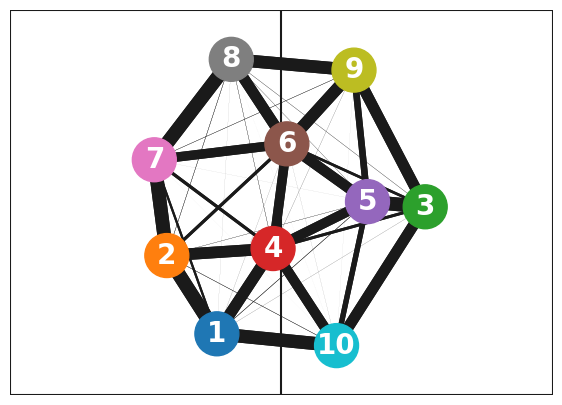

In [33]:
FormManager.visualize_single_graph(mean_role_coords, mean_edge_mat)
plt.savefig(f'img/mean_mat.png', bbox_inches='tight')